In [1]:
import altair as alt

from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core import Traffic
from traffic.core.projection import EuroPP

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

# Original Data

In [2]:
original_traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_noga_tilFAF.pkl")
original_traffic

,count
flight_id,
2FPLF_000,200
SWR2291_9681,200
SWR2277_9599,200
SWR2277_9600,200
SWR2277_9601,200
SWR2277_9602,200
SWR2277_9603,200
SWR2277_9604,200
SWR2277_9605,200


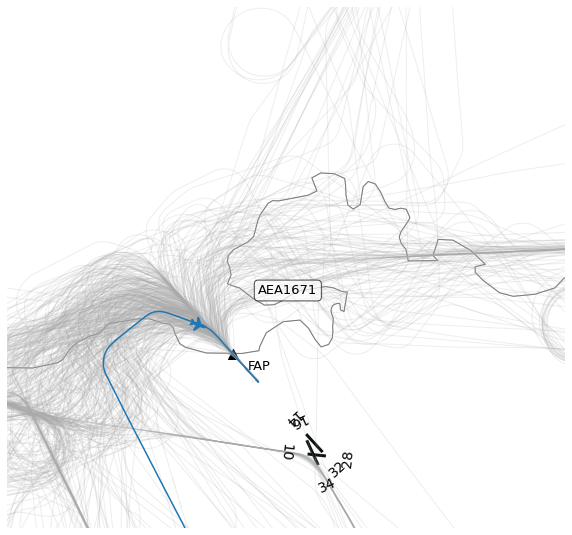

In [3]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports

disp = original_traffic[:500]
i = np.random.randint(len(disp))

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    disp.plot(ax, alpha=0.2)
    disp[i].plot(ax, color="#1f77b4", lw=1.5)
    disp[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )


    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )
    

# TCVAE

In [4]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 14399
    MinMaxScaler(feature_range=(-1, 1))

In [5]:
from os import walk

filenames = next(walk("../../deep_traffic_generation/lightning_logs/tcvae/version_8/checkpoints"), (None, None, []))[2]

model = TCVAE.load_from_checkpoint(
    "../../deep_traffic_generation/lightning_logs/tcvae/version_8/checkpoints/" + filenames[0],
    hparams_file="../../deep_traffic_generation/lightning_logs/tcvae/version_8/hparams.yaml",
    dataset_params=dataset.parameters,
)
model.eval()

TCVAE(
  (encoder): Sequential(
    (0): TCN(
      (network): Sequential(
        (0): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(4, 64, kernel_size=(16,), stride=(1,))
            (out_activ): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,))
            (out_activ): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (downsample): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
            (out_activ): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
            (out_activ): ReLU()
            (d

# Reconstruction

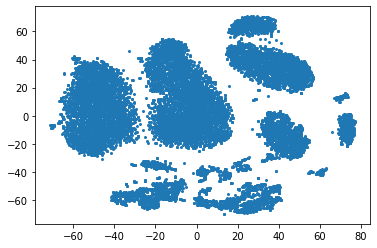

In [6]:
#Latent Space
h = model.encoder(dataset.data)
q = model.lsr(h)
z = q.rsample()
x = z.detach().cpu()

x_embedded = TSNE(n_components=2).fit_transform(x.numpy())
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], s=4)
plt.show()

ON PEUT IDENTIFIER LES TRAJECTOIRES AVEC UN HOLDING PATTERN :  ELLES SONT SEPAREES DANS L'ESPACE LATENT. Mais elles sont très mal reconstruites

In [7]:
a = np.where(x_embedded[:,0] < -60)[0]
print(len(a)/len(x_embedded))

ab = list(map(int,a))
holding = list(np.array(original_traffic.flight_ids)[ab])
no_holding = [item for item in original_traffic.flight_ids if item not in holding]
#Il est possible que les holdings soient relativement mal appris car la base est trop petite.
#Que se passe-t-il si on augmente la base et le nombre de holding ?

0.021529272866171262


In [8]:
from traffic.drawing import countries

holding = list(np.array(original_traffic.flight_ids)[ab])
no_holding = [item for item in original_traffic.flight_ids if item not in holding]

t_hold = original_traffic.assign(holding = lambda x: x.flight_id.isin(holding))
t_hold.to_pickle("../deep_traffic_generation/data/traffic_162-216_noga_tilFAF_withHOLD.pkl")

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    original_traffic[holding].plot(ax, alpha=0.5, color="c")

FileNotFoundError: [Errno 2] No such file or directory: '../deep_traffic_generation/data/traffic_162-216_noga_tilFAF_withHOLD.pkl'

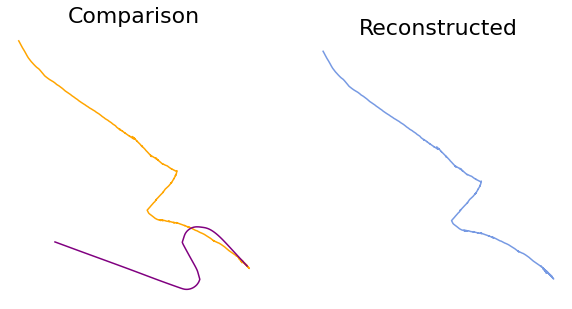

In [12]:
### Reconstruction
i = np.random.randint(len(dataset))
# i = np.random.choice(a)
original, info = dataset[i]
_, _, reconstruction = model(original.unsqueeze(0))
data = torch.cat((original.unsqueeze(0).transpose(1, 2), reconstruction.detach().transpose(1, 2)))
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

#add lat/lon info
info = info.repeat(2, 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]

reconstruction = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)
# reconstruction = traffic_from_data(
#     data, features, ["init1", "init2"], builder=builder
# )
# reconstruction.drop(["init1", "init2"], axis = 1, inplace = True)

# if "track" not in reconstruction.data.columns:
#     reconstruction = (
#     reconstruction
#     .cumulative_distance()
#     .rename(columns=dict(compute_gs="groundspeed", compute_track="track"))
#     .eval(desc="")
# )

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    reconstruction[1].plot(ax[0], c="orange", label="reconstructed")
    reconstruction[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    reconstruction[1].plot(ax[1])

    plt.show()

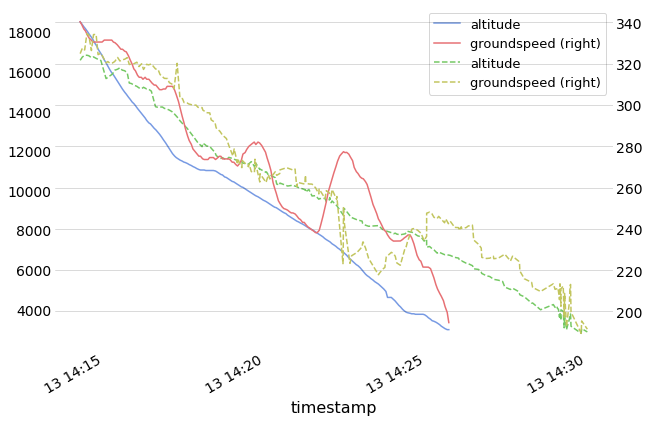

In [13]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    reconstruction[0].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"]
    )
    reconstruction[1].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"], ls="--"
    )

Le Réseau de neurone peut-aussi être utilisé pour faire du débruitage. Lors de la reconstruction, les features sont généralement plus smooth que les originales, tout en étant fidèles.

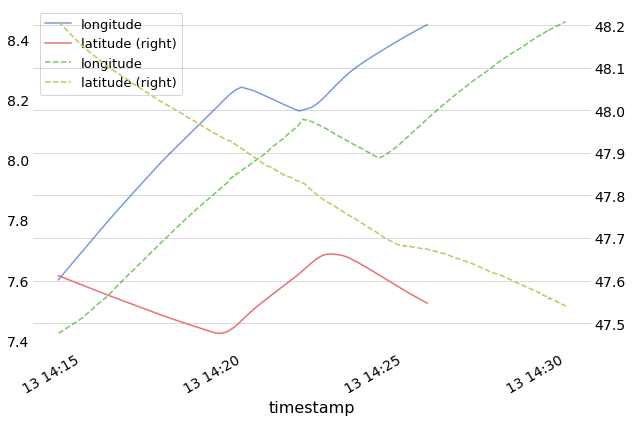

In [14]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    reconstruction[0].plot_time(
        ax, y=["longitude","latitude"], secondary_y=["latitude"]
    )
    reconstruction[1].plot_time(
        ax, y=["longitude","latitude"], secondary_y=["latitude"], ls="--"
    )

  0%|          | 0/2 [00:00<?, ?it/s]

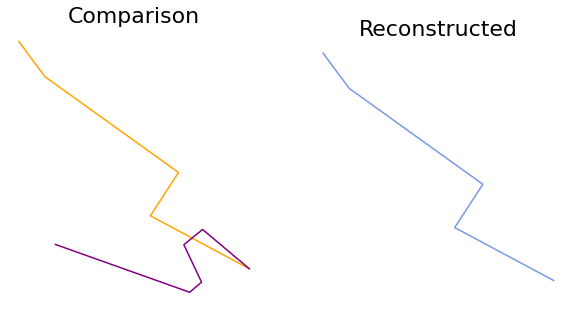

In [15]:
simplified_rec = (
    reconstruction
    .simplify(tolerance=3e3)
    .eval(desc="")
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    simplified_rec[1].plot(ax[0], c="orange", label="reconstructed")
    simplified_rec[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    simplified_rec[1].plot(ax[1])

    plt.show()

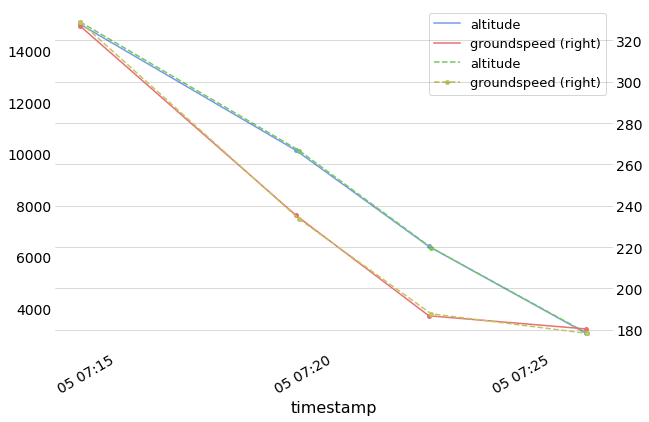

In [20]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    simplified_rec[0].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"], marker = "."
    )
    simplified_rec[1].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"], marker = ".", ls="--"
    )

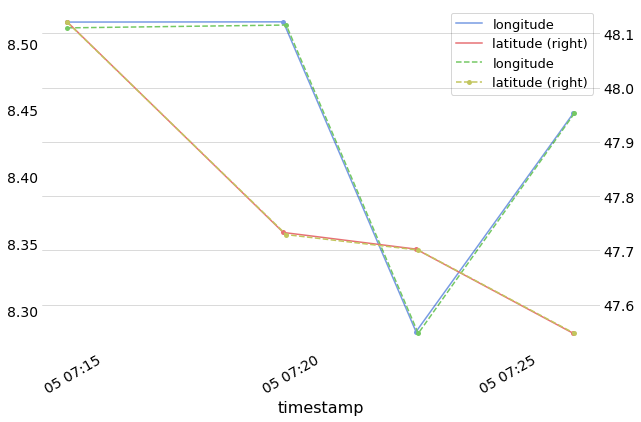

In [21]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    simplified_rec[0].plot_time(
        ax, y=["longitude","latitude"], secondary_y=["latitude"], marker = "."
    )
    simplified_rec[1].plot_time(
        ax, y=["longitude","latitude"], secondary_y=["latitude"], ls="--", marker = "."
    )

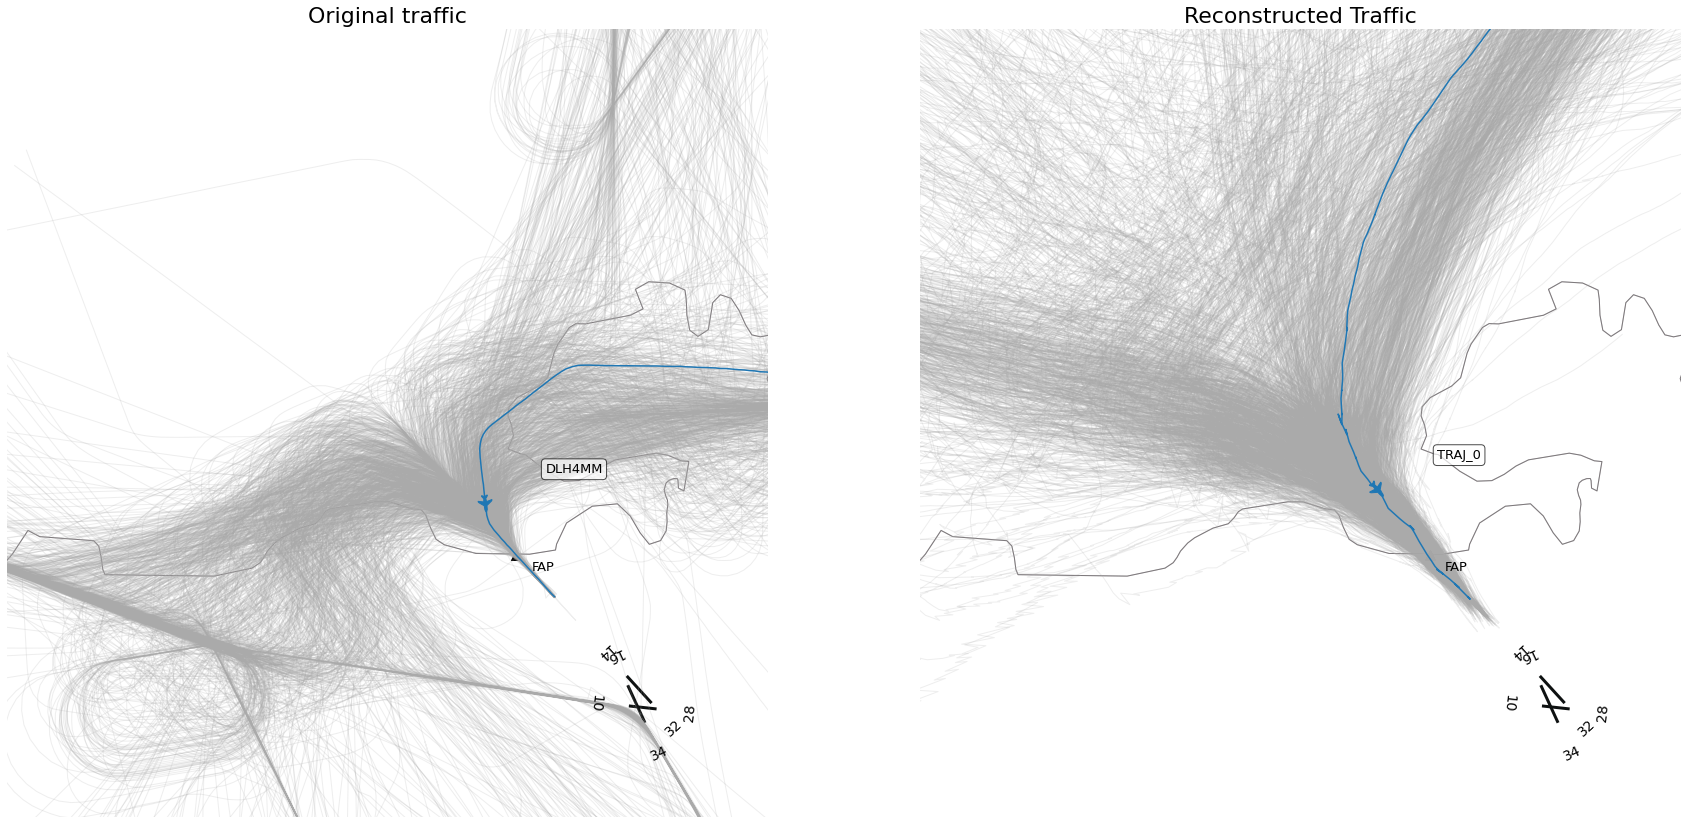

In [16]:
#original dataset
n_disp = 2000
disp = original_traffic[:n_disp]
i = np.random.randint(len(disp))

#Reconstructed dataset
h = model.encoder(dataset.data[:n_disp])
q = model.lsr(h)
z = q.rsample()
x = z.detach().cpu()
x_reconst = model.decoder(x)
x_reconst = x_reconst.detach().transpose(1,2).reshape(x_reconst.shape[0],-1)
data = dataset.scaler.inverse_transform(x_reconst)

# add latitude longitude info
_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(len(x_reconst), 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
generation = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

#highlighted
h_h = model.encoder(dataset.data[i].unsqueeze(dim = 0))
q_h = model.lsr(h_h)
z_h = q_h.rsample()
x_h = z_h.detach().cpu()
x_reconst_h = model.decoder(x_h)
x_reconst_h = x_reconst_h.detach().transpose(1,2).reshape(x_reconst_h.shape[0],-1)
data_h = dataset.scaler.inverse_transform(x_reconst_h)

# add latitude longitude info
_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(len(x_reconst_h), 1)
data_h = np.concatenate((info.numpy(), data_h), axis=1)

builder_h = model.get_builder(data_h.shape[0], dataset.seq_len)
generation_h = traffic_from_data(
    data_h, features, model.dataset_params["info_params"]["features"], builder=builder_h
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, figsize=(30, 50), subplot_kw=dict(projection=EuroPP()))

    ax[0].add_feature(countries())
    ax[0].figure
    ax[0].set_extent((7.8, 8.7, 47.37, 48))
    ax[0].set_title("Original traffic")

    ax[1].add_feature(countries())
    ax[1].figure
    ax[1].set_extent((7.8, 8.7, 47.37, 48))
    ax[1].set_title("Reconstructed Traffic")

    disp.plot(ax[0], alpha=0.2)
    disp[i].plot(ax[0], color="#1f77b4", lw=1.5)
    disp[i].at_ratio(0.85).plot(
        ax[0],
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    generation.plot(ax[1], alpha=0.2)
    generation_h[0].plot(ax[1], color="#1f77b4", lw=1.5)
    generation_h[0].at_ratio(0.85).plot(
        ax[1],
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax[0], footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax[0],
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

    airports["LSZH"].plot(ax[1], footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax[1],
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax[0],
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

    navaids["OSNEM"].plot(
        ax[1],
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Interpolated Trajectories

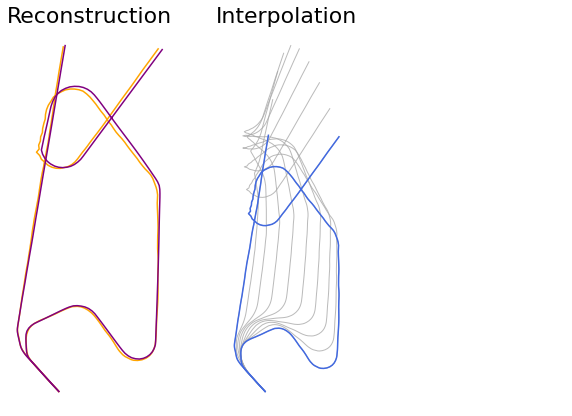

In [69]:
# i = np.random.randint(len(dataset))
# j = np.random.randint(len(dataset))
i = 1436
j = 2815

original, info = dataset[[i,j]]

#Latent Variables
h = model.encoder(dataset.data)
q = model.lsr(h)
z = q.rsample()
z = z.detach().numpy()

#interpolated latent variables
z1 = z[i]
z2 = z[j]
lambdas = list(np.linspace(0,1,10))
z_inter = []
for lam in lambdas:
    z_inter.append(lam*z1 + (1-lam)*z2)
z_inter = np.array(z_inter)


reco_x = model.decoder(torch.Tensor(z_inter))
reco_x = reco_x.detach().transpose(1,2).reshape(reco_x.shape[0],-1)
data = torch.cat((original.transpose(1, 2).reshape(original.shape[0],-1), reco_x))
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

#add lat/lon info
info = info.repeat(int(len(data)/2), 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]

reconstruction = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Reconstruction")
    reconstruction["TRAJ_2"].plot(ax[0], c="orange", label="reconstructed")
    reconstruction["TRAJ_11"].plot(ax[0], c="orange", label="reconstructed")
    reconstruction[:2].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Interpolation")
    reconstruction[2:].plot(ax[1], label = "interpolated")
    reconstruction["TRAJ_2"].plot(ax[1], c = "royalblue", label = "reconstructed")
    reconstruction["TRAJ_11"].plot(ax[1], c = "royalblue", label = "reconstructed")


    plt.show()



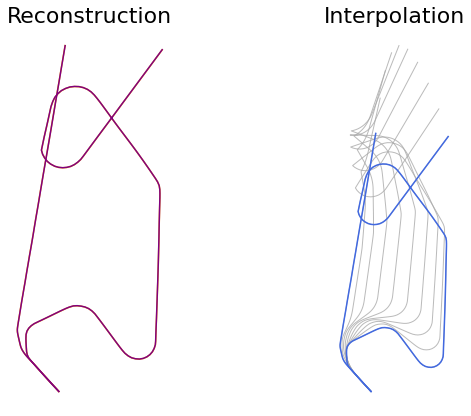

In [70]:
original, info = dataset[[i,j]]
original = original.transpose(1, 2).reshape(original.shape[0],-1)

#interpolated latent variables
lambdas = list(np.linspace(0,1,10))
x_inter = []
for lam in lambdas:
    x_inter.append(lam*original[0].detach().numpy() + (1-lam)*original[1].detach().numpy())
x_inter = torch.Tensor(np.array(x_inter))


data = torch.cat((original, x_inter))
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

#add lat/lon info
info = info.repeat(int(len(data)/2), 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]

reconstruction = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Reconstruction")
    reconstruction["TRAJ_2"].plot(ax[0], c="orange", label="reconstructed")
    reconstruction["TRAJ_11"].plot(ax[0], c="orange", label="reconstructed")
    reconstruction[:2].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Interpolation")
    reconstruction[2:].plot(ax[1], label = "interpolated")
    reconstruction["TRAJ_2"].plot(ax[1], c = "royalblue", label = "reconstructed")
    reconstruction["TRAJ_11"].plot(ax[1], c = "royalblue", label = "reconstructed")

    plt.show()



# Generation using a priori

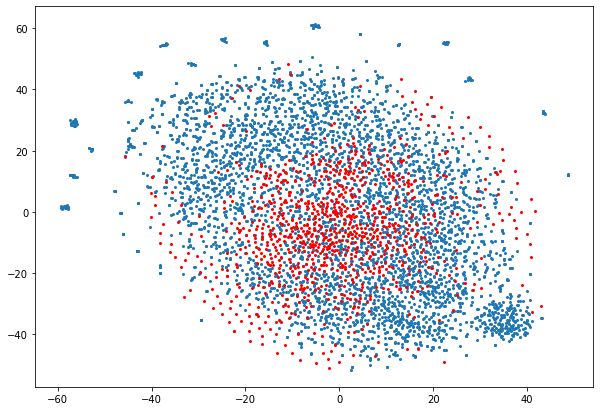

In [46]:
N_SAMPLES = 1000
p = model.lsr.get_prior(N_SAMPLES)
z_sim = p.sample()

h = model.encoder(dataset.data)
q = model.lsr(h)
z = q.rsample()
x = z.detach().cpu().numpy()


encodings = np.concatenate((x, z_sim), axis=0)
encodings_embedded = TSNE(n_components=2).fit_transform(encodings)

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.scatter(encodings_embedded[:-N_SAMPLES, 0], encodings_embedded[:-N_SAMPLES, 1], s=4)
ax.scatter(encodings_embedded[-N_SAMPLES:, 0], encodings_embedded[-N_SAMPLES:, 1], s=4, c='red')
plt.show()

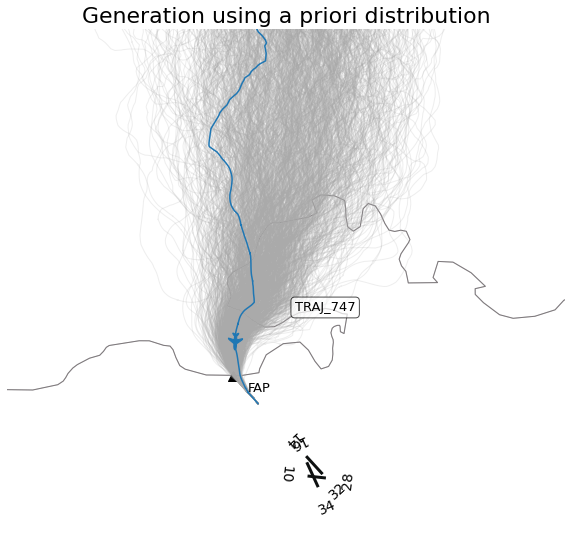

In [47]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports

x_sim = model.decoder(z_sim)
x_sim = x_sim.detach().transpose(1,2).reshape(x_sim.shape[0],-1)
data = dataset.scaler.inverse_transform(x_sim)

# add latitude longitude info
_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(N_SAMPLES, 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
generation = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

#generation = traffic_from_data(
#    data, features, ["init1", "init2"], builder=builder
#)
#generation.drop(["init1", "init2"], axis = 1, inplace = True)

i = np.random.randint(len(generation))

#generation = generation.simplify(tolerance=2e3, altitude = "altitude").eval(desc="", max_workers = 20)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))
    ax.set_title("Generation using a priori distribution")

    generation.plot(ax, alpha=0.2)
    generation[i].plot(ax, color="#1f77b4", lw=1.5)
    generation[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Generation using a posteriori distribution

In [35]:
h = model.encoder(dataset.data)
q = model.lsr(h)
params = model.lsr.dist_params(q)

#sanity check
# mean of Q(z) = E(q(z|x))
print(params[1].mean(axis = 0))

#variance of Q(z)
print((params[1]**2).mean(axis = 0) + (params[2]**2).mean(axis = 0))
print(params[2].mean(axis = [1,2]).max())

#Effectivement, la loi de la posteriori est assez différent d'une N(0,1)

tensor([[ 8.1852e-03, -7.7560e-02, -6.3908e-03, -7.5328e-01,  3.6249e-02,
         -5.1486e-02,  5.5101e-03, -4.3039e-03, -1.1135e-02,  8.5684e-01,
         -2.5406e-02, -1.5192e-01, -2.4101e-02, -1.4253e-02, -2.9686e-02,
         -6.0692e-02, -3.5190e-02,  1.1814e+00, -1.9288e-02,  2.2124e-02,
          2.9618e-02, -3.3362e-02, -1.8362e-02, -1.2999e-03,  4.6879e-02,
          2.3149e-02,  8.9368e-03,  2.8716e-02, -1.1505e-01, -2.1190e-02,
          1.4074e-02,  2.7165e-02,  2.1630e-02,  3.8971e-01,  2.5776e-02,
          1.6521e-02, -2.1204e-04, -1.6520e-02, -8.5195e-03,  1.8398e-02,
         -1.8889e-02, -2.5881e-02,  4.2983e-01, -3.7875e-03,  2.0736e-03,
          5.0910e-02,  2.2669e-02, -1.2586e+00, -6.2928e-04,  8.1341e-02,
          2.7702e-02,  3.0324e-02, -1.6999e-03,  7.9808e-03,  4.0133e-03,
         -2.3278e-02,  1.5927e-02, -5.9390e-03, -3.4748e-02, -3.6734e-02,
         -1.4028e-03, -2.2985e-02,  4.2483e-02, -3.9401e-02,  2.1809e-02,
         -1.0214e-01,  3.3825e-02,  5.

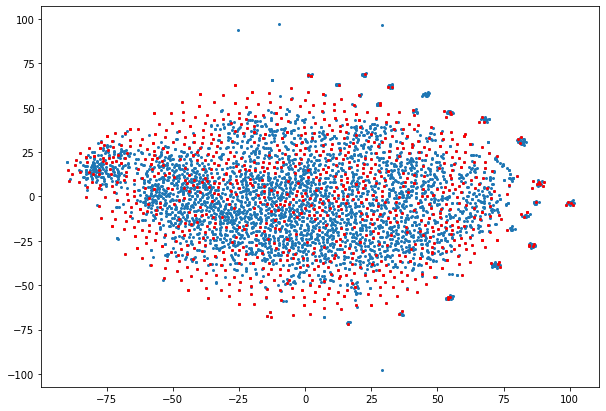

In [36]:
#The global distribution of the latent space is a GMM of 4414 components (number of input)
#With weights = 1
#each component is estimated within the latent space

N_SAMPLES = 1000

h = model.encoder(dataset.data)
q = model.lsr(h)
params = model.lsr.dist_params(q)

mix = torch.distributions.Categorical(torch.ones(len(dataset.data),))
#we take 0 because the a priori is a GMM of 1 comp
comp = torch.distributions.Independent(torch.distributions.Normal(params[1][:,0,:], params[2][:,0,:]), 1)

gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
z_sim = gmm.sample(sample_shape=torch.Size([1000]))

z = q.rsample()
x = z.detach().cpu().numpy()


encodings = np.concatenate((x, z_sim), axis=0)
encodings_embedded = TSNE(n_components=2).fit_transform(encodings)

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.scatter(encodings_embedded[:-N_SAMPLES, 0], encodings_embedded[:-N_SAMPLES, 1], s=4)
ax.scatter(encodings_embedded[-N_SAMPLES:, 0], encodings_embedded[-N_SAMPLES:, 1], s=4, c='red')
plt.show()

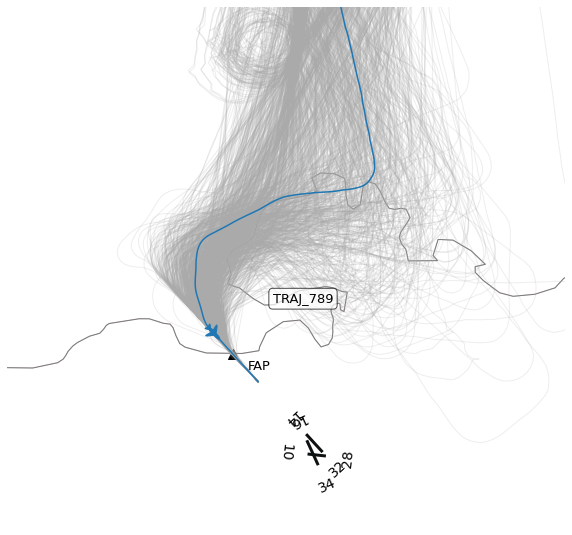

In [37]:
x_sim = model.decoder(z_sim)
x_sim = x_sim.detach().transpose(1,2).reshape(x_sim.shape[0],-1)
data = dataset.scaler.inverse_transform(x_sim)

# add latitude longitude info
_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(N_SAMPLES, 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
generation = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

#generation = traffic_from_data(
#    data, features, ["init1", "init2"], builder=builder
#)
#generation.drop(["init1", "init2"], axis = 1, inplace = True)

i = np.random.randint(len(generation))

#generation = generation.simplify(tolerance=2e3, altitude = "altitude").eval(desc="", max_workers = 20)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    generation.plot(ax, alpha=0.2)
    generation[i].plot(ax, color="#1f77b4", lw=1.5)
    generation[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

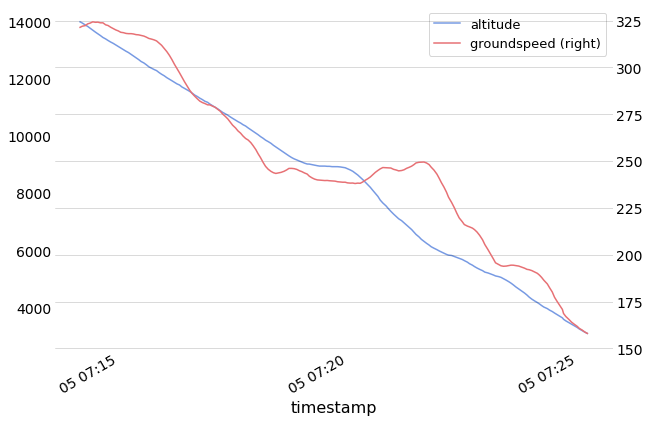

In [38]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    generation[int(i)].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"]
    )